In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torchphysics as tp
import numpy as np
import torch
import pytorch_lightning as pl

In [2]:
radius = 5.0
widht, height = 0.5, 4.0
t_0, t_end = 0.0, 1.0
a_0, a_end = np.pi, 2*np.pi # rotation speed
k_cool, k_hot = 270, 330 # temperature values
mu = 2.0 # viscosity
lamb = 0.5 # heat diffusion

def start_fn(t, a):
    return 1 - torch.exp(-a*t)
# dont want to jump from initial temperature to k_hot
def heat_up_fn(t, a):
    return k_cool + (k_hot - k_cool) * start_fn(t, a)

In [3]:
X = tp.spaces.R2('x') # space
T = tp.spaces.R1('t') # time
A = tp.spaces.R1('a') # rotation speed
U = tp.spaces.R2('u') # velocity
P = tp.spaces.R1('p') # pressure
K = tp.spaces.R1('k') # temperature

In [4]:
def rotation_function(a, t):
    # rotate clockwise and use t*(1-e^-at) -> velocity has a smooth start up
    return - a * t * start_fn(t, a)

circle = tp.domains.Circle(X, [0.0, 0.0], radius)
rod = tp.domains.Parallelogram(X, [-widht, -height], [widht, -height], [-widht, height])
rod = tp.domains.Rotate.from_angles(rod, rotation_function)
omega = circle - rod
t_int = tp.domains.Interval(T, t_0, t_end)
a_int = tp.domains.Interval(A, a_0, a_end)

In [6]:
# model for velocity and pressure
ac_fn = tp.models.AdaptiveActivationFunction(torch.nn.Tanh())
model_u = tp.models.Sequential(
    tp.models.NormalizationLayer(circle*t_int*a_int),
    tp.models.FCN(input_space=X*T*A, output_space=U, hidden=(100,100,100,100,100,100,100), 
                  activations=ac_fn)
)
model_p = tp.models.Sequential(
    tp.models.NormalizationLayer(circle*t_int*a_int),
    tp.models.FCN(input_space=X*T*A, output_space=P, hidden=(80,80,80,80,80,80))
)
ac_fn_temp = tp.models.AdaptiveActivationFunction(torch.nn.Tanh())
model_k = tp.models.Sequential(
    tp.models.NormalizationLayer(circle*t_int*a_int),
    tp.models.FCN(input_space=X*T*A, output_space=K, hidden=(100,100,100,100,100,100,100), 
                  activations=ac_fn_temp)
)


## load models:
model_u.load_state_dict(torch.load('../final_u.pt'))
model_k.load_state_dict(torch.load('../final_temp.pt'))

# constrain for the velocity:
# outer boundary u = 0 and initialy u = 0
def constrain_fn_u(u, x, t, a):
    time_scale = start_fn(t, a)
    rot_speed = radius*a*torch.column_stack((torch.cos(-a*t*time_scale), 
                                            torch.sin(-a*t*time_scale)))
    rot_speed *= (1 - torch.exp(-a*t) + a*t*torch.exp(-a*t))
    distance = x[:, :1]**2 + x[:, 1:]**2
    u_con = rot_speed * u * (1 - distance / radius**2)
    return u_con
# constrain for the pressure:
# initialy p = 0
def constrain_fn_p(p, t, a):
    p_con = p * start_fn(t, a)
    return p_con
# constrain for the temperature:
# initialy k = k_cool and on outer boundary k = k_cool
def constrain_fn_k(k, x, t, a):
    distance = x[:, :1]**2 + x[:, 1:]**2
    k_con = (k_hot - k_cool) * start_fn(t, a) * k * (1.0 - distance/radius**2) + k_cool
    return k_con


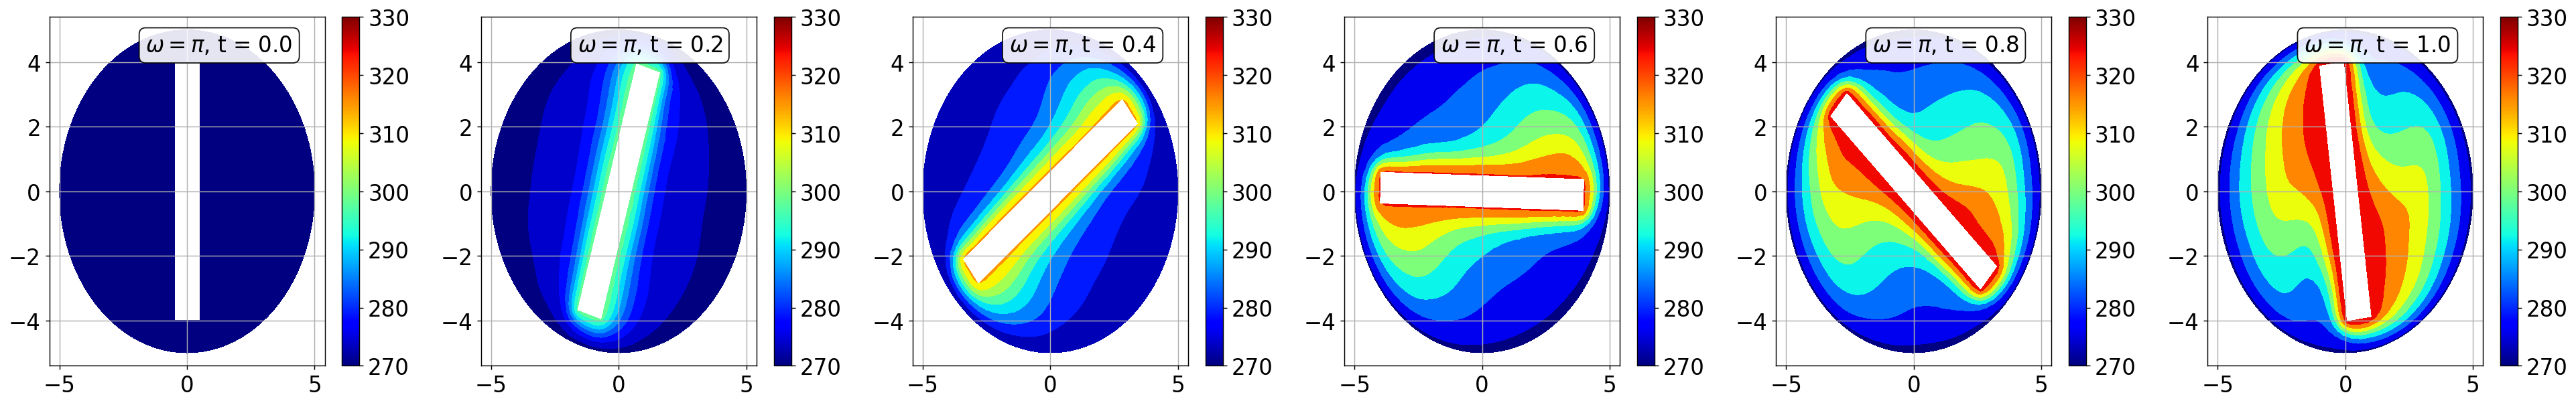

In [9]:
import matplotlib.pyplot as plt 
import matplotlib.tri as mtri
from matplotlib import cm
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = [30.0, 5]
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 1.6
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['figure.dpi'] = 130

fig = plt.figure()
a_value = np.pi
time_steps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

points = np.load("vertex_points.npy")
connection = np.load("connections.npy")
a = torch.tensor(a_value * np.ones_like(points[:, :1]), dtype=torch.float32)
points = torch.tensor(points, dtype=torch.float32)

for i in range(len(time_steps)):
    # rotate points
    angle = rotation_function(torch.tensor(time_steps[i]), torch.tensor(a_value))
    matrix = torch.tensor([[torch.cos(angle - np.pi/2.0), -torch.sin(angle - np.pi/2.0)],
                           [torch.sin(angle - np.pi/2.0), torch.cos(angle - np.pi/2.0)]])
    matrix = matrix.reshape(-1, 2, 2)
    p = torch.matmul(matrix, points.reshape(-1, 2, 1)).squeeze(-1)
    # model evaluation
    t = time_steps[i] * torch.ones_like(points[:, :1])
    tp_points = tp.spaces.Points(torch.column_stack((p, t, a)), X*T*A)
    out = model_k(tp_points).as_tensor.detach()
    out = constrain_fn_k(out, p, t, a)
    # plot
    ax = fig.add_subplot(1, len(time_steps), i+1)
    ax.grid()
    ax.set_xlim((-5.4, 5.4))
    ax.set_ylim((-5.4, 5.4))
    # helper for correct colorbar
    con = [ax.scatter([0, 0], [0, 1], c=[k_cool, k_hot],
                    vmin=k_cool, vmax=k_hot, cmap=cm.jet)]
    plt.colorbar(con[0])
    con[0].remove()
    triangulation = mtri.Triangulation(x=p[:, 0], y=p[:, 1], triangles=connection)
    ax.tricontourf(triangulation, out.flatten(), cmap=cm.jet, 
                        vmin=k_cool, vmax=k_hot)
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    ax.text(0.35, 0.95, r"$\omega = \pi$, " + 't = '+ str(time_steps[i]), transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props, ha='left')
    #plt.legend([r"$\omega = 2\pi$, " + 't = '+ str(time_steps[i])])
plt.tight_layout()

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-10-8e1f0147fdbc>:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  xx = torch.stack((XP, YP)).T.reshape(-1, 2)


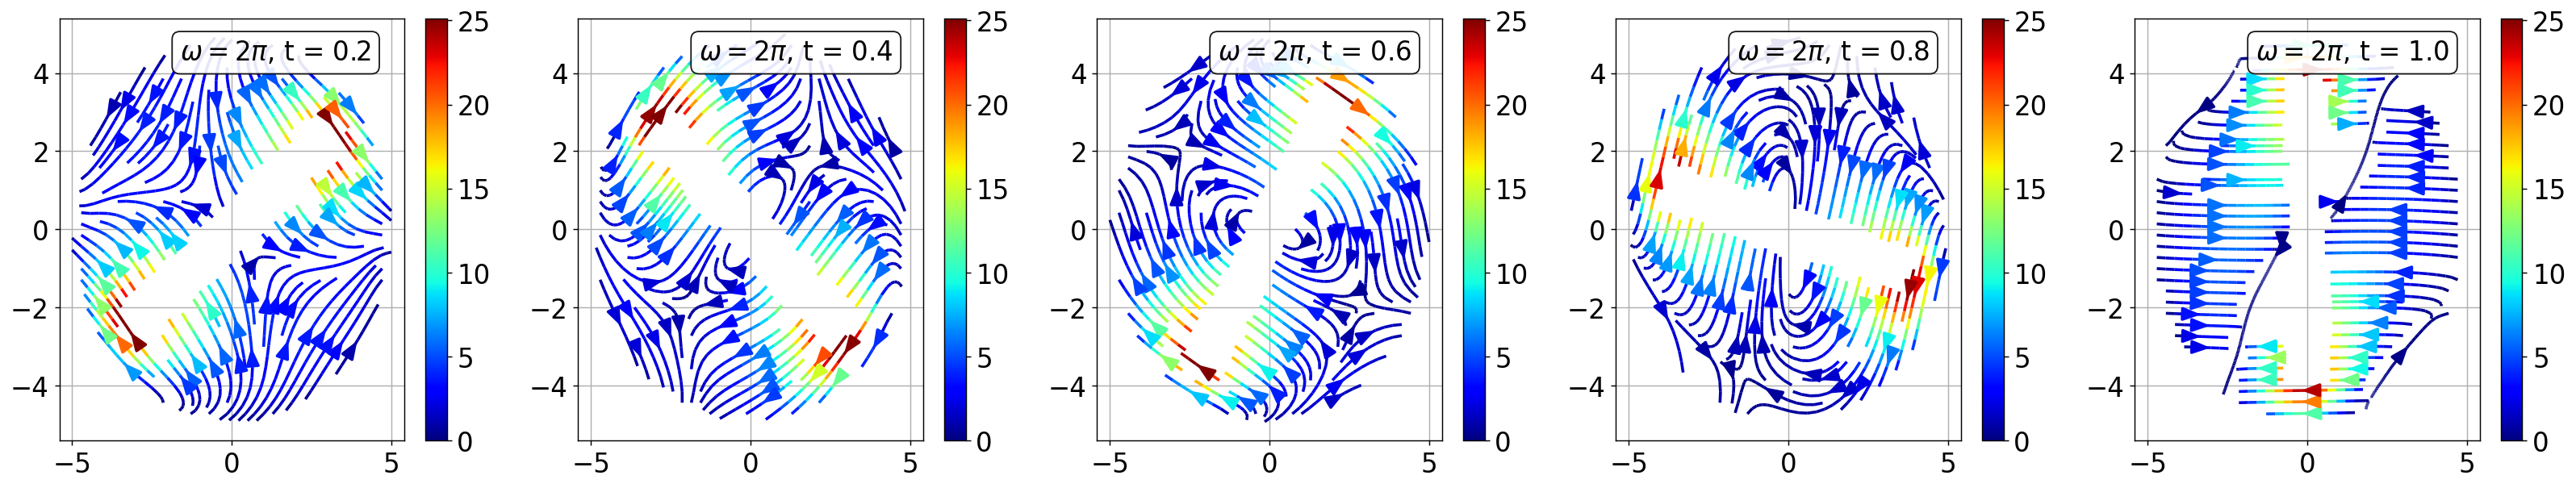

In [10]:
import matplotlib.pyplot as plt 
import matplotlib.tri as mtri
from matplotlib import cm, colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = [25.0, 5]
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 1.6
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['figure.dpi'] = 130

a_value = 2*np.pi
time_steps = [0.2, 0.4, 0.6, 0.8, 1.0]
max_norm = 2*np.pi*4
fig = plt.figure()

x = torch.linspace(-5, 5, 200)
y = torch.linspace(-5, 5, 200)
XP, YP = torch.meshgrid((x, y))
xx = torch.stack((XP, YP)).T.reshape(-1, 2)
a = torch.tensor(a_value * np.ones_like(xx[:, :1]), dtype=torch.float32)
x = x.detach().numpy()
y = y.detach().numpy()
for i in range(len(time_steps)):
    # model evaluation
    t = time_steps[i] * torch.ones_like(xx[:, :1])
    tp_points = tp.spaces.Points(torch.column_stack((xx, t, a)), X*T*A)
    out = model_u(tp_points).as_tensor.detach()
    out = constrain_fn_u(out, xx, t, a)
    not_in_domain = torch.logical_not(torch.logical_or(omega.boundary._contains(tp_points), 
                                                       omega._contains(tp_points)))
    out[not_in_domain[:, 0], :] = torch.nan
    out = out.detach().numpy().T.reshape(2, 200, 200)
    # Create the plot
    # plot
    ax = fig.add_subplot(1, len(time_steps), i+1)
    ax.grid()
    ax.set_xlim((-5.4, 5.4))
    ax.set_ylim((-5.4, 5.4))
    # helper for correct colorbar
    con = [ax.scatter([0, 0], [0, 1], c=[0.0, max_norm],
                    vmin=0.0, vmax=max_norm, cmap=cm.jet)]
    plt.colorbar(con[0])
    con[0].remove()
    U = out[0]
    V = out[1]
    col = np.sqrt(U**2 + V**2)
    norm = colors.Normalize(vmin=0,vmax=max_norm, clip=False)
    #quiv = ax.quiver(p[:, 0], p[:, 1], out[:, 0], out[:, 1], color=cmap_plot, clim=[0.0,20.0])
    ax.streamplot(x, y, U, V, density=1.2, arrowstyle=mpl.patches.ArrowStyle("simple", head_width=0.75, head_length=1.0), 
                  color=col, cmap=cm.jet, norm=norm, linewidth=2.0)
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    ax.text(0.35, 0.95, r"$\omega = 2\pi$, " + 't = '+ str(time_steps[i]), transform=ax.transAxes, fontsize=18,
                verticalalignment='top', bbox=props, ha='left')
    #sm = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    #plt.colorbar(sm, ax=ax)
plt.tight_layout()

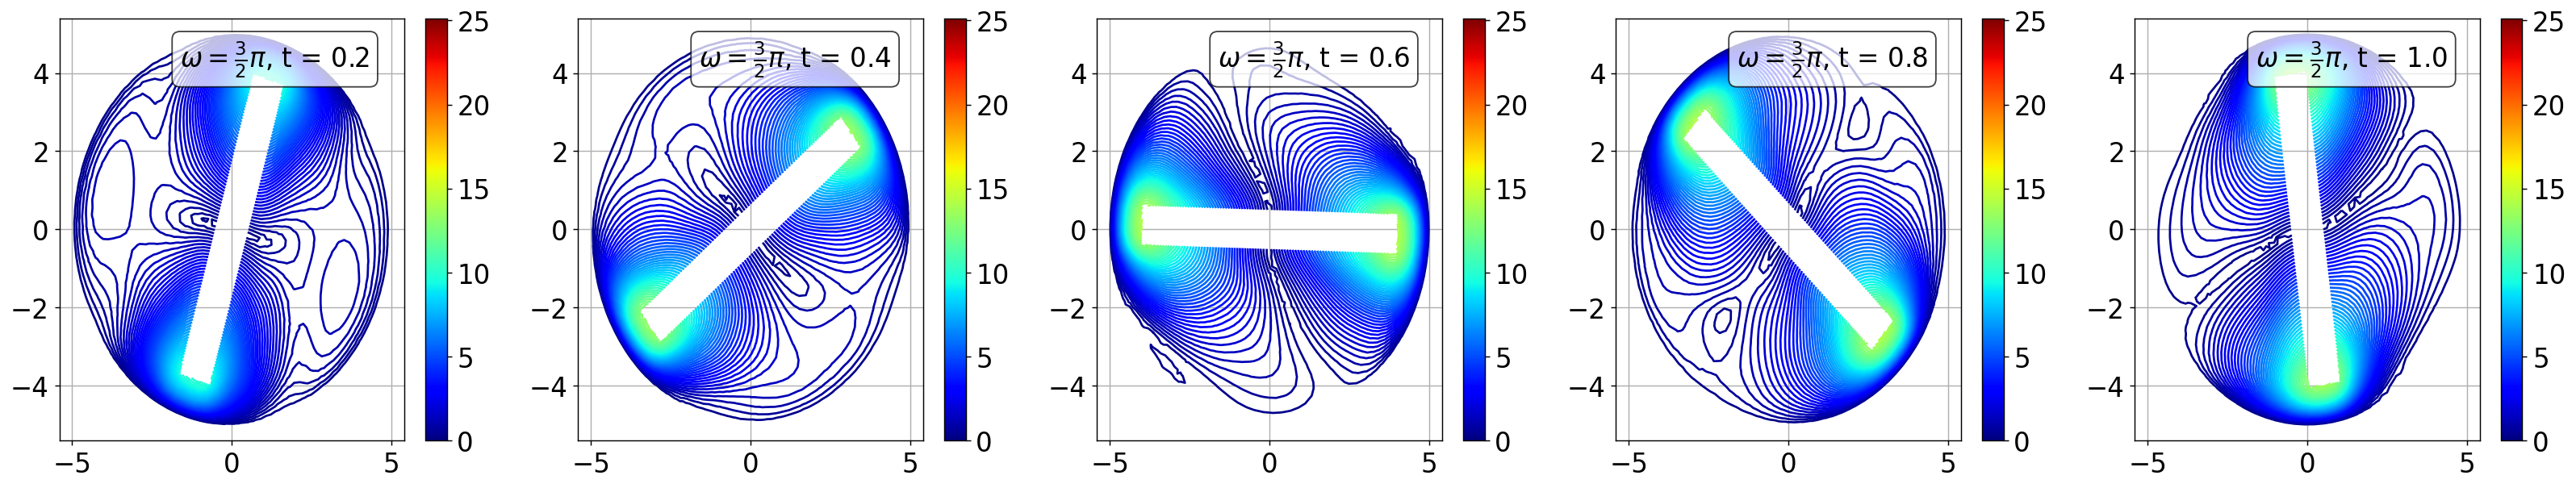

In [11]:
import matplotlib.pyplot as plt 
import matplotlib.tri as mtri
from matplotlib import cm, colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = [25.0, 5]
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 1.6
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['figure.dpi'] = 130

a_value = np.pi
time_steps = [0.2, 0.4, 0.6, 0.8, 1.0]
max_norm = 2*np.pi*4
fig = plt.figure()
points = np.load("vertex_points.npy")
connection = np.load("connections.npy")
a = torch.tensor(a_value * np.ones_like(points[:, :1]), dtype=torch.float32)
points = torch.tensor(points, dtype=torch.float32)

for i in range(len(time_steps)):
    # rotate points
    angle = rotation_function(torch.tensor(time_steps[i]), torch.tensor(a_value))
    matrix = torch.tensor([[torch.cos(angle - np.pi/2.0), -torch.sin(angle - np.pi/2.0)],
                           [torch.sin(angle - np.pi/2.0), torch.cos(angle - np.pi/2.0)]])
    matrix = matrix.reshape(-1, 2, 2)
    p = torch.matmul(matrix, points.reshape(-1, 2, 1)).squeeze(-1)
    # model evaluation
    t = time_steps[i] * torch.ones_like(points[:, :1])
    tp_points = tp.spaces.Points(torch.column_stack((p, t, a)), X*T*A)
    out = model_u(tp_points).as_tensor.detach()
    out = constrain_fn_u(out, p, t, a)
    # color
    color = np.linalg.norm(out, axis=1) 
    norm = colors.Normalize(vmin=0,vmax=25, clip=False)
    #scale the arrows
    #max_norm = np.max(color)
    #out /= max_norm
    norm.autoscale(color)
    # Create the plot
    # plot
    ax = fig.add_subplot(1, len(time_steps), i+1)
    ax.grid()
    ax.set_xlim((-5.4, 5.4))
    ax.set_ylim((-5.4, 5.4))
    # helper for correct colorbar
    con = [ax.scatter([0, 0], [0, 1], c=[0.0, max_norm],
                    vmin=0.0, vmax=max_norm, cmap=cm.jet)]
    plt.colorbar(con[0])
    con[0].remove()
    #quiv = ax.quiver(p[:, 0], p[:, 1], out[:, 0], out[:, 1], color=cmap_plot, clim=[0.0,20.0])
    triangulation = mtri.Triangulation(x=p[:, 0], y=p[:, 1], triangles=connection)
    ax.tricontour(triangulation, torch.sqrt(out[:, 0]**2 + out[:, 1]**2), cmap=cm.jet, 
                  vmin=0.0, vmax=max_norm, linewidths=1.5, levels=50)
    props = dict(boxstyle='round', facecolor='w', alpha=0.75)
    ax.text(0.35, 0.95, r"$\omega = \frac{3}{2}\pi$, " + 't = '+ str(time_steps[i]), transform=ax.transAxes, fontsize=18,
                verticalalignment='top', bbox=props, ha='left')
    #sm = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    #plt.colorbar(sm, ax=ax)
plt.tight_layout()